# VGG16 and UNET with Synthetic Dataset (added Skip connection, batchnormalization)

In [2]:
# Data Processing and Visualization
import os                  # Operating system-specific functionalities
import random              # Generates pseudo-random numbers
import glob                # Finds all the pathnames matching a specified pattern
import re                  # Regular expression operations

# Data Manipulation and Analysis
import numpy as np         # Fundamental package for scientific computing with Python
import pandas as pd        # Data manipulation and analysis library

# Image Processing and Visualization
import matplotlib.pyplot as plt   # Data visualization library
import cv2                        # OpenCV for image processing
from skimage import io            # Image I/O library from scikit-image

# Deep Learning Framework (TensorFlow/Keras)
import tensorflow as tf                     # Open-source machine learning library
from tensorflow.keras.layers import (       # Keras layers for building neural networks
    Conv2D, BatchNormalization, Activation, Conv2DTranspose, Concatenate, Input
)
from tensorflow.keras.models import Model   # Model class for defining neural network models
from tensorflow.keras.applications import VGG16  # Pre-trained VGG16 model

# Specific TensorFlow/Keras Components
from tensorflow.keras import layers, optimizers  # Different components for building and training neural networks
from tensorflow.keras.initializers import glorot_uniform  # Glorot (Xavier) weight initializer
from tensorflow.keras.utils import plot_model  # Utility for plotting model architectures
from tensorflow.keras.callbacks import (  # Callbacks for adjusting learning rate during training
    ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
)
import tensorflow.keras.backend as K  # Keras backend for low-level operations

# Other Libraries
from sklearn.preprocessing import StandardScaler, normalize  # For data preprocessing
from sklearn.model_selection import train_test_split # For Train Test Split
from IPython.display import display  # Display utilities for IPython environments
from keras.models import load_model  # Loading models in Keras
from keras.losses import binary_crossentropy  # Binary cross-entropy loss function


In [3]:
data_map = []

# Specify the path to your dataset on your Windows machine
dataset_path = "Seg_MRI"

# Iterate over subdirectories in the specified path
for sub_dir_path in glob.glob(dataset_path + "\\*"):
    # Check if the current path is a directory
    if os.path.isdir(sub_dir_path):
        try:
            dir_name = sub_dir_path.split('\\')[-1]

            # Iterate over files in the directory
            for filename in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, filename)
                data_map.extend([dir_name, image_path])
        except Exception as e:
            print(e)

# Display the data_map
print(data_map)


['Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_000.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_000_mask.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_001.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_001_mask.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_002.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_002_mask.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_003.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_003_mask.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_004.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_004_mask.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_005.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_005_mask.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_006.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE_006_mask.tif', 'Astrocytoma', 'Seg_MRI\\Astrocytoma\\Astrocytoma_T1CE

In [4]:
df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()


,patient_id,path
0,Astrocytoma,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000.tif
1,Astrocytoma,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000_mask.tif
2,Astrocytoma,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_001.tif
3,Astrocytoma,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_001_mask.tif
4,Astrocytoma,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_002.tif


In [5]:
# Filtering image paths
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

# Creating a dictionary for mask paths
mask_dict = {path[:-9]: path for path in df_masks["path"].values}

# Pairing each image with its corresponding mask
pairs = []
for img_path in df_imgs["path"].values:
    mask_path = mask_dict.get(img_path[:-4])  # Remove the '.tif' from the image path
    if mask_path:
        pairs.append((img_path, mask_path))

# Randomly selecting one pair of image and mask
idx = random.randint(0, len(pairs)-1)
img_path, mask_path = pairs[idx]
print("Path to the Image:", img_path, "\nPath to the Mask:", mask_path)


Path to the Image: Seg_MRI\Glioblastoma\Glioblastoma_flair_040.tif 
Path to the Mask: Seg_MRI\Glioblastoma\Glioblastoma_flair_040mask_.tif


In [6]:
# Final dataframe
brain_df = pd.DataFrame(pairs, columns=["image_path", "mask_path"])

# Extract patient_id from image_path
brain_df["patient_id"] = brain_df["image_path"].apply(lambda x: x.split("\\")[-2])

def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))
brain_df


,image_path,mask_path,patient_id,mask
0,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000.tif,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_000_mask.tif,Astrocytoma,1
1,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_001.tif,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_001_mask.tif,Astrocytoma,1
2,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_002.tif,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_002_mask.tif,Astrocytoma,1
3,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_003.tif,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_003_mask.tif,Astrocytoma,1
4,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_004.tif,Seg_MRI\Astrocytoma\Astrocytoma_T1CE_004_mask.tif,Astrocytoma,1
...,...,...,...,...
556,Seg_MRI\Neurocytoma\94.tif,Seg_MRI\Neurocytoma\94_mask.tif,Neurocytoma,1
557,Seg_MRI\Neurocytoma\95.tif,Seg_MRI\Neurocytoma\95_mask.tif,Neurocytoma,1
558,Seg_MRI\Neurocytoma\96.tif,Seg_MRI\Neurocytoma\96_mask.tif,Neurocytoma,1
559,Seg_MRI\Neurocytoma\97.tif,Seg_MRI\Neurocytoma\97_mask.tif,Neurocytoma,1


In [7]:
brain_df['mask'].value_counts()

mask
1    559
0      2
Name: count, dtype: int64

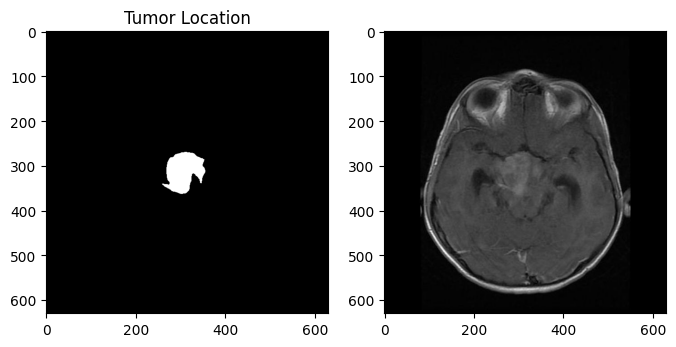

In [8]:
for i in range(len(brain_df)):
    if cv2.imread(brain_df.mask_path[i]).max() > 0:
        break

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(cv2.imread(brain_df.mask_path[i]));
plt.title('Tumor Location')

plt.subplot(1,2,2)
plt.imshow(cv2.imread(brain_df.image_path[i]));

In [9]:
cv2.imread(brain_df.mask_path[i]).max(), cv2.imread(brain_df.mask_path[i]).min()

(255, 0)

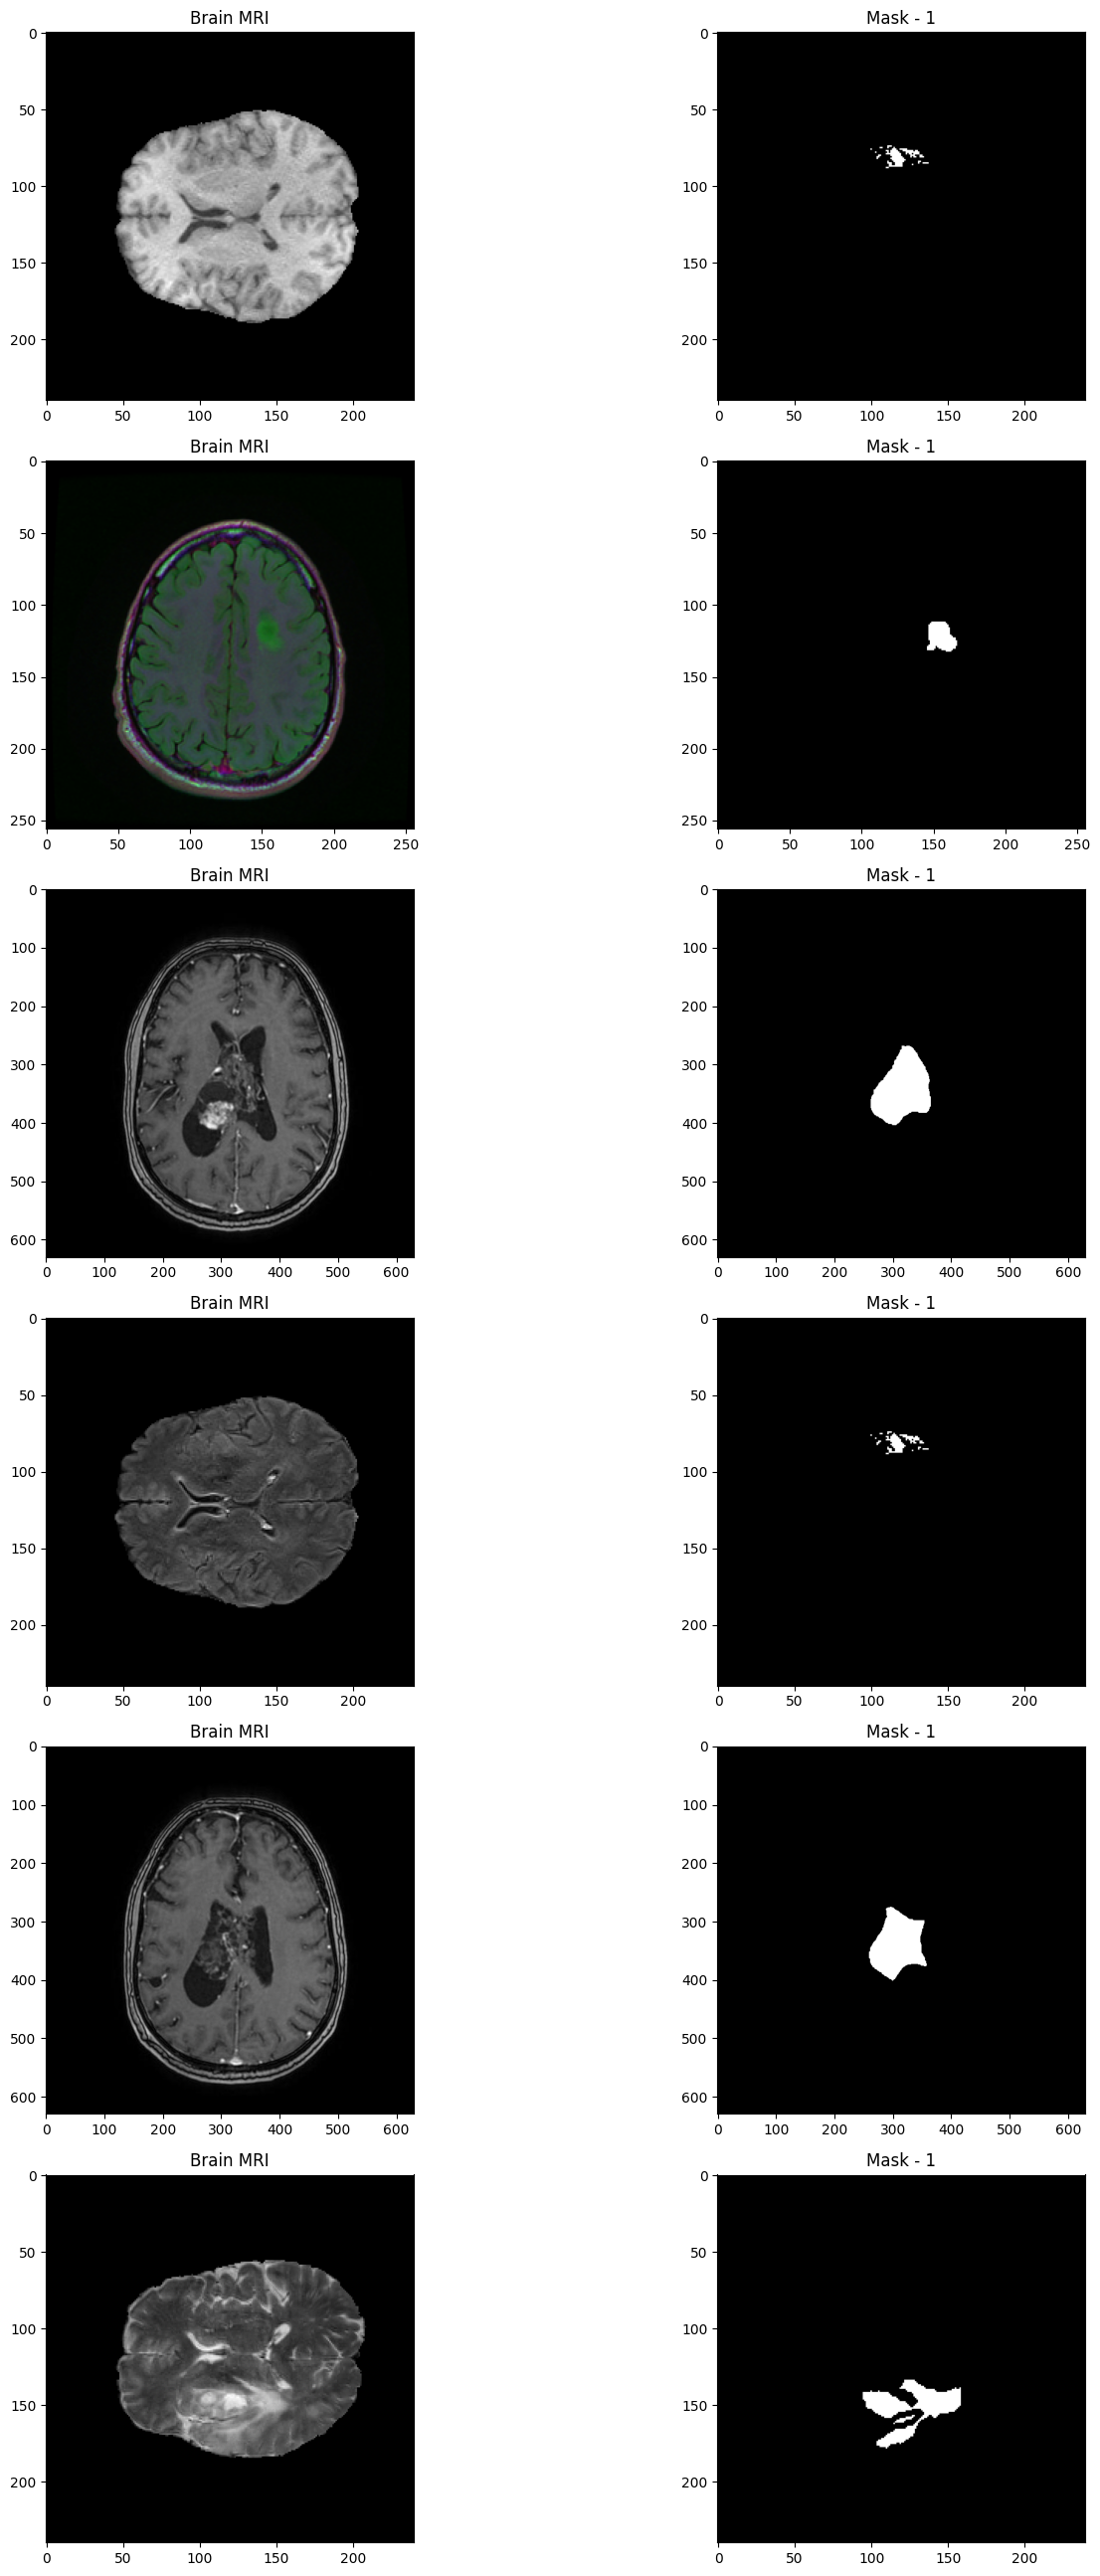

In [10]:
# Basic visualizations: Visualize the images (MRI and Mask) in the dataset separately

fig, axs = plt.subplots(6,2, figsize=(16,26))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # select a random index
  axs[count][0].title.set_text("Brain MRI") # set title
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # show MRI
  axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i])) # plot title on the mask (0 or 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Show corresponding mask
  count += 1

fig.tight_layout()

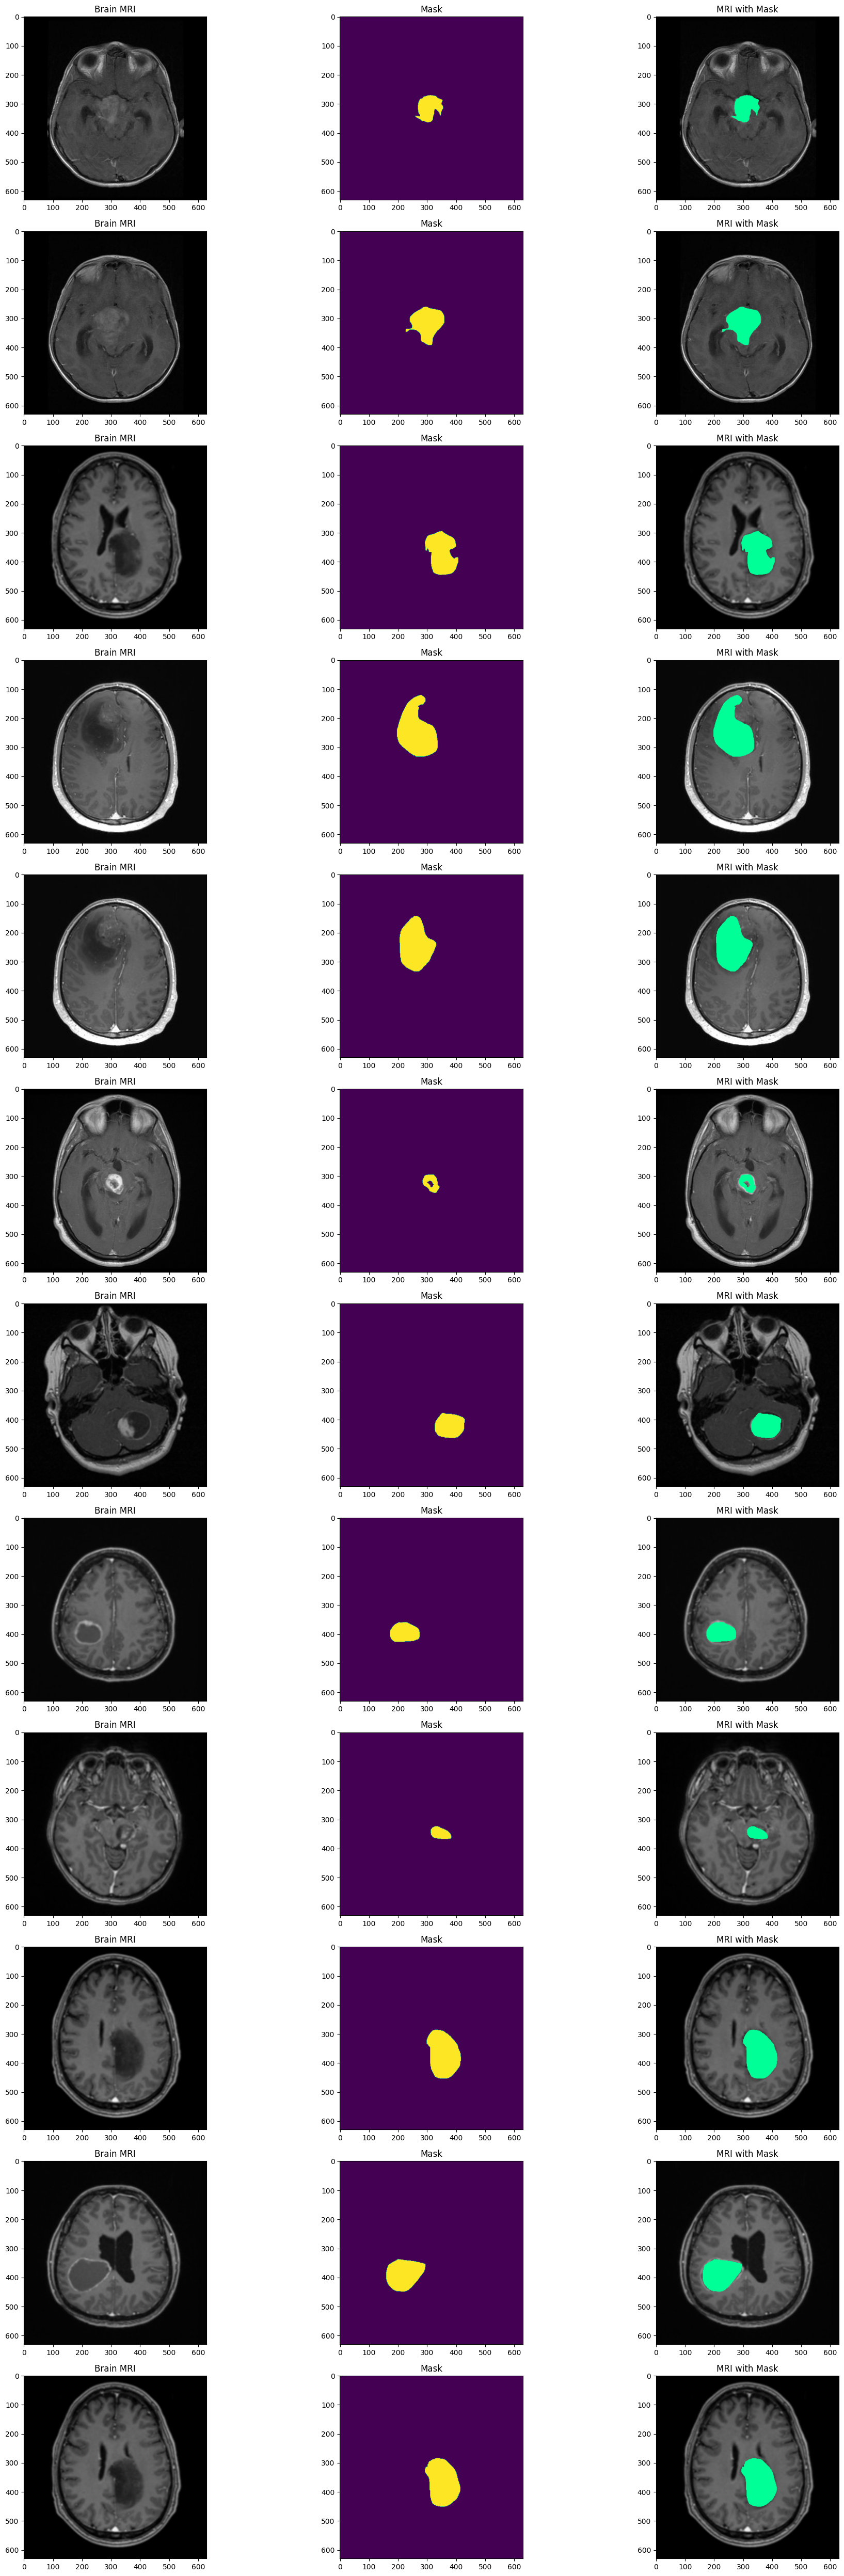

In [11]:
count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))
for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("Brain MRI")
        axs[count][0].imshow(img)

        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Mask")
        axs[count][1].imshow(mask)

        img[mask==255] = (0,255,150)  # change pixel color at the position of mask
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break

fig.tight_layout()

In [12]:
brain_df_train = brain_df.drop(columns=['patient_id'])
# Convert the data in mask column to string format, to use categorical mode in flow_from_dataframe
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  561 non-null    object
 1   mask_path   561 non-null    object
 2   mask        561 non-null    object
dtypes: object(3)
memory usage: 13.3+ KB


In [13]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(559, 4)

In [14]:
train, test = train_test_split(brain_df_train, test_size=0.15)

# creating test, train and val sets
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Train size is {}, valid size is {} & test size is {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Train size is 475, valid size is 42 & test size is 42


In [15]:
import cv2

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, image_dir='.\\', batch_size=16, img_h=256, img_w=256, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Get the number of batches per epoch'
        return int(np.floor(len(self.image_paths)) / self.batch_size)

    def __getitem__(self, index):
        'Generate a batch of data'
        indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        list_image_paths = [self.image_paths[i] for i in indexes]
        list_mask_paths = [self.mask_paths[i] for i in indexes]

        X, y = self.__data_generation(list_image_paths, list_mask_paths)
        return X, y

    def on_epoch_end(self):
        'Used for updating the indices after each epoch, once at the beginning as well as at the end of each epoch'
        self.indexes = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_image_paths, list_mask_paths):
        'Generate the data corresponding to the indexes in a given batch of images'
        X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

        for i in range(len(list_image_paths)):
            image_path = str(list_image_paths[i])
            mask_path = str(list_mask_paths[i])

            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path)

            if image is None or mask is None:
                print(f"Warning: Image or mask is empty at path: {image_path}, {mask_path}")
                continue

            try:
                image = cv2.resize(image, (self.img_h, self.img_w))
                mask = cv2.resize(mask, (self.img_h, self.img_w))
            except cv2.error as e:
                print(f"Error resizing image: {e}")
                print(f"Image path: {image_path}")
                continue

            image = image.astype(np.float32) / 255.0  # Normalize image
            mask = mask.astype(np.float32) / 255.0  # Normalize mask

            X[i,] = image
            y[i,] = np.expand_dims(mask[:, :, 0], axis=2)  # Assuming mask has single channel

        return X, y

# Example usage:
train_data = DataGenerator(image_paths=train_ids, mask_paths=train_mask)
val_data = DataGenerator(image_paths=val_ids, mask_paths=val_mask)

# Check the input image dimensions and channels
input_height = train_data.img_h
input_width = train_data.img_w
input_channels = 3  # Assuming RGB images are used
print(f"Input image dimensions: {input_height} x {input_width} x {input_channels}")


Input image dimensions: 256 x 256 x 3


In [16]:
from tensorflow.keras.layers import Input, Conv2D, Activation, Concatenate, Conv2DTranspose, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg16_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG16 Model """
    vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg16.get_layer("block1_conv2").output
    s2 = vgg16.get_layer("block2_conv2").output
    s3 = vgg16.get_layer("block3_conv3").output
    s4 = vgg16.get_layer("block4_conv3").output

    """ Bridge """
    b1 = vgg16.get_layer("block5_conv3").output  # Note: block5_conv3 in VGG16

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG16_U-Net")
    return model

# Example usage:
seg_model = build_vgg16_unet((256, 256, 3))
seg_model.summary()


Model: "VGG16_U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 256,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 128,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 128,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 128,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 64,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 64,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 64,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 64,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 32,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 32,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 32,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 32,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 16,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 16,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 16,    │  2,359,808 │ block5_conv1[0][

 Total params: 25,862,337 (98.66 MB)

 Trainable params: 25,858,497 (98.64 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [17]:
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.cast(K.flatten(y_true), dtype='float32')
    y_pred_pos = K.cast(K.flatten(y_pred), dtype='float32')
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [18]:
adam = tf.keras.optimizers.Adam(learning_rate=0.05, epsilon=0.1)
seg_model.compile(optimizer=adam,
                  loss=focal_tversky,
                  metrics=[tversky]
                 )

# callbacks
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=20,
                              restore_best_weights=True  # Add this line to restore best weights
                             )

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights\\my_model_unet_sythetic_v6_03.keras",
                               verbose=1,
                               save_best_only=True,
                              )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )


In [18]:
h = seg_model.fit(train_data,
                  epochs=200,
                  validation_data=val_data,
                  callbacks=[checkpointer, earlystopping, reduce_lr],
                  verbose=1  # Add verbose for more information during training
                 )



Epoch 1/200


C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 16s/step - loss: 0.9252 - tversky: 0.0984 
Epoch 1: val_loss improved from inf to 0.91494, saving model to weights\my_model_unet_sythetic_v6_03.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 469s 16s/step - loss: 0.9249 - tversky: 0.0988 - val_loss: 0.9149 - val_tversky: 0.1118 - learning_rate: 0.0500
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 0.8903 - tversky: 0.1434 
Epoch 2: val_loss improved from 0.91494 to 0.91406, saving model to weights\my_model_unet_sythetic_v6_03.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 449s 15s/step - loss: 0.8901 - tversky: 0.1437 - val_loss: 0.9141 - val_tversky: 0.1129 - learning_rate: 0.0500
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - loss: 0.8667 - tversky: 0.1734 
Epoch 3: val_loss improved from 0.91406 to 0.89497, saving model to weights\my_model_unet_sythetic_v6_03.keras
29/29 ━━━━━━━━━━━━━━━━━━━━ 449s 15s/step - loss: 0.8665 - tversky: 0.1737 - val_loss: 0.8950 - val_tversky: 0.1375 - learning_rate: 0.0500
Epoch 4/200

In [19]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)
test_data = DataGenerator(test_ids, test_mask)
_, tv = seg_model.evaluate(test_data)
print("Segmentation tversky is {:.2f}%".format(tv*100))

C:\Users\Implici7\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9398 - tversky: 0.0795
Segmentation tversky is 8.16%


In [20]:
model_path = "weights\\my_model_unet_sythetic_v6_03.keras"
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

loaded_model = load_model(model_path, custom_objects={
    'tversky': tversky,
    'focal_tversky': focal_tversky,
    'tversky_loss': tversky_loss
})

In [23]:
import numpy as np
import cv2
from skimage import io
import matplotlib.pyplot as plt

def visualize_segmentation_results(model, X_test):
    # Loop through each row in X_test
    for index, row in X_test.head(6).iterrows():
        # Load the image
        img_path = row['image_path']
        img = io.imread(img_path)
        img = cv2.resize(img, (256, 256))
        img = np.array(img, dtype=np.float64)
        img -= img.mean()
        img /= img.std()

        # Load the original mask
        orig_mask_path = row['mask_path']
        orig_mask = io.imread(orig_mask_path)
        orig_mask = cv2.resize(orig_mask, (256, 256))

        # Create X array for prediction
        X = np.empty((1, 256, 256, 3))
        X[0, ] = img

        # Make prediction of mask
        predict = model.predict(X)
        pred_mask = np.array(predict).squeeze().round()

        # Plotting the images
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(img)
        plt.title('Image')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(orig_mask, cmap='gray')
        plt.title('Original Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(img)
        plt.imshow(orig_mask, alpha=0.5, cmap='jet')
        plt.title('Image with Original Mask')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(img)
        plt.imshow(pred_mask, alpha=0.5, cmap='jet')
        plt.title('Image with Predicted Mask')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


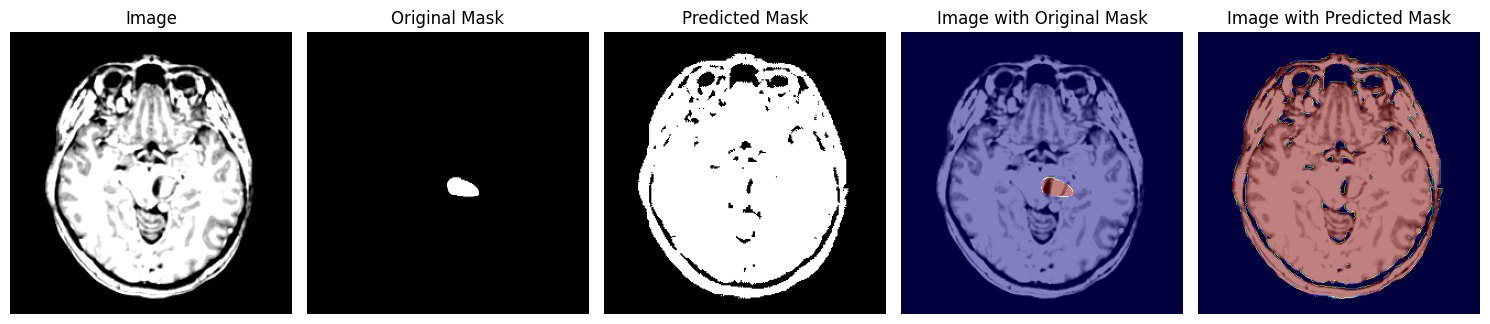

ValueError: could not broadcast input array from shape (256,256) into shape (256,256,3)

In [24]:
visualize_segmentation_results(loaded_model, X_test)

In [45]:
# Assuming loaded_model is your pre-trained model
test_data = DataGenerator(test_ids, test_mask)

# Evaluate the model on the test set
loss, accuracy = loaded_model.evaluate(test_data)

# Print the results
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')


AttributeError: 'NoneType' object has no attribute 'items'

In [46]:
import matplotlib.pyplot as plt

# Assuming loaded_model is your pre-trained model
test_data = DataGenerator(test_ids, test_mask)

# Initialize lists to store cumulative results
test_losses = []
test_accuracies = []

# Evaluate the model on each batch of the test set
for batch_x, batch_y in test_data:
    # Evaluate the model on the batch
    loss, accuracy = loaded_model.evaluate(batch_x, batch_y, verbose=0)
    
    # Append results to lists
    test_losses.append(loss)
    test_accuracies.append(accuracy)

# Plotting the incremental results
plt.figure(figsize=(12, 4))

# Plot Incremental Test Loss
plt.subplot(1, 2, 1)
plt.plot(test_losses, marker='o', linestyle='-', color='blue')
plt.title('Loss Function')
plt.xlabel('Test Samples')
plt.ylabel('Loss')

# Plot Incremental Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o', linestyle='-', color='green')
plt.title('Accuracy')
plt.xlabel('Test Samples')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'items'

In [47]:
from sklearn.metrics import f1_score

# Assuming loaded_model is your pre-trained model
test_data = DataGenerator(test_ids, test_mask)

# Make predictions on the test set
predictions = loaded_model.predict(test_data)

# Flatten the predictions and ground truth masks
predictions_flat = predictions.flatten()
ground_truth_flat = np.concatenate([batch_y.flatten() for _, batch_y in test_data])

# Convert probabilities to binary predictions
binary_predictions = (predictions_flat > 0.5).astype(int)

# Calculate F1 score
f1 = f1_score(ground_truth_flat, binary_predictions)

# Print the F1 score
print(f'F1 Score: {f1}')


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


MemoryError: Unable to allocate 4.00 MiB for an array with shape (16, 256, 256, 1) and data type int32

1/1 [==============================] - 4s 4s/step


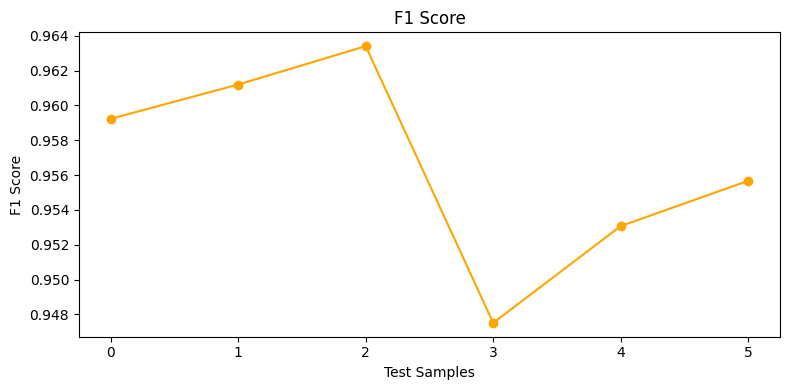

In [28]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Assuming loaded_model is your pre-trained model
test_data = DataGenerator(test_ids, test_mask)

# Initialize lists to store cumulative results
f1_scores = []

# Make predictions on each batch of the test set
for batch_x, batch_y in test_data:
    # Get predictions
    predictions = loaded_model.predict(batch_x)
    
    # Flatten the predictions and ground truth masks
    predictions_flat = predictions.flatten()
    ground_truth_flat = batch_y.flatten()

    # Convert probabilities to binary predictions
    binary_predictions = (predictions_flat > 0.5).astype(int)

    # Calculate F1 score
    f1 = f1_score(ground_truth_flat, binary_predictions)

    # Append results to the list
    f1_scores.append(f1)

# Plotting the incremental results
plt.figure(figsize=(8, 4))

# Plot Incremental F1 Score
plt.plot(f1_scores, marker='o', linestyle='-', color='orange')
plt.title('F1 Score')
plt.xlabel('Test Samples')
plt.ylabel('F1 Score')

plt.tight_layout()
plt.show()


1/1 [==============================] - 4s 4s/step


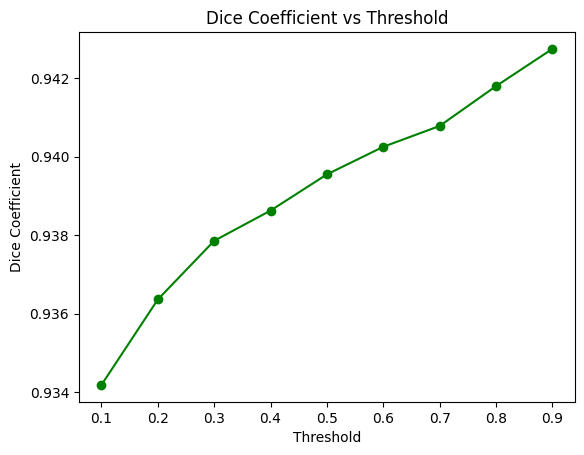

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coefficient(y_true, y_pred, threshold=0.5):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > threshold).astype(int)
    
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    
    dice = (2.0 * intersection + 1e-5) / (union + 1e-5)
    return dice

def plot_dice_threshold_curve(model, test_data):
    thresholds = np.arange(0.1, 1.0, 0.1)
    dice_scores = []

    for threshold in thresholds:
        current_dice_scores = []

        for batch_x, batch_y in test_data:
            predictions = model.predict(batch_x)
            for i in range(len(predictions)):
                dice_score = dice_coefficient(batch_y[i], predictions[i], threshold=threshold)
                current_dice_scores.append(dice_score)

        average_dice_score = np.mean(current_dice_scores)
        dice_scores.append(average_dice_score)

    # Plotting the Dice coefficient over different thresholds
    plt.plot(thresholds, dice_scores, marker='o', linestyle='-', color='green')
    plt.title('Dice Coefficient vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Dice Coefficient')
    plt.show()

# Example usage:
test_data = DataGenerator(test_ids, test_mask)
plot_dice_threshold_curve(loaded_model, test_data)


1/1 [==============================] - 4s 4s/step


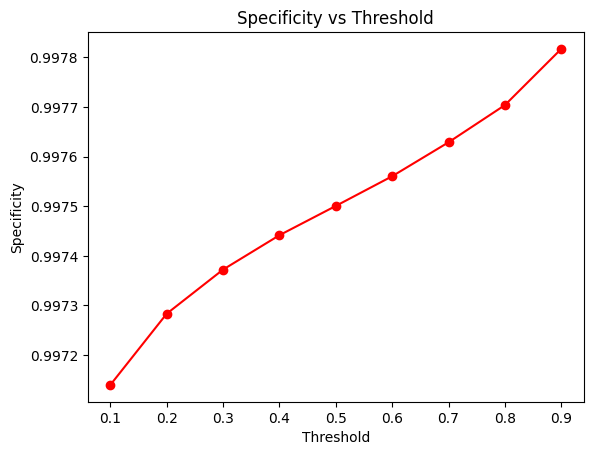

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def specificity(y_true, y_pred, threshold=0.5):
    y_true = y_true.flatten()
    y_pred = (y_pred.flatten() > threshold).astype(int)

    true_negative = np.sum((y_true == 0) & (y_pred == 0))
    false_positive = np.sum((y_true == 0) & (y_pred == 1))

    specificity = true_negative / (true_negative + false_positive + 1e-5)
    return specificity

def plot_specificity_threshold_curve(model, test_data):
    thresholds = np.arange(0.1, 1.0, 0.1)
    specificity_scores = []

    for threshold in thresholds:
        current_specificity_scores = []

        for batch_x, batch_y in test_data:
            predictions = model.predict(batch_x)
            for i in range(len(predictions)):
                specificity_score = specificity(batch_y[i], predictions[i], threshold=threshold)
                current_specificity_scores.append(specificity_score)

        average_specificity_score = np.mean(current_specificity_scores)
        specificity_scores.append(average_specificity_score)

    # Plotting the Specificity over different thresholds
    plt.plot(thresholds, specificity_scores, marker='o', linestyle='-', color='red')
    plt.title('Specificity vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('Specificity')
    plt.show()

# Example usage:
test_data = DataGenerator(test_ids, test_mask)
plot_specificity_threshold_curve(loaded_model, test_data)


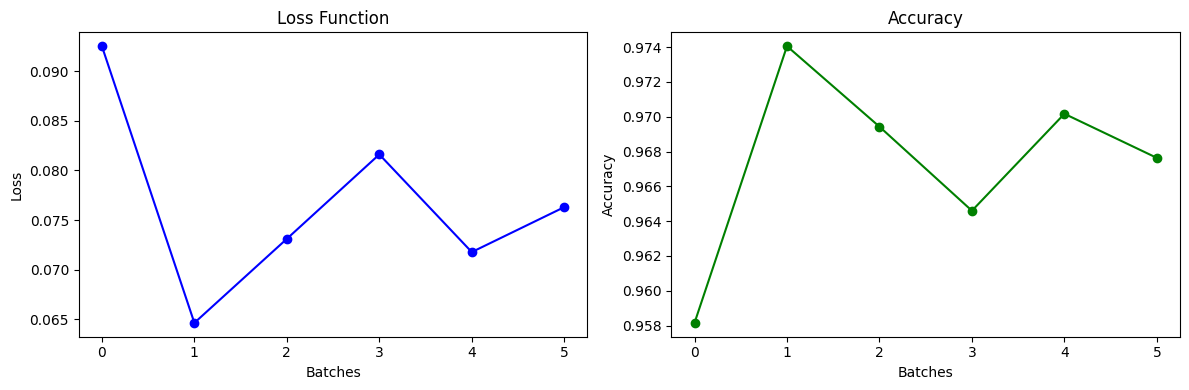

In [51]:
import matplotlib.pyplot as plt

# Assuming loaded_model is your pre-trained model
test_data = DataGenerator(test_ids, test_mask)

# Initialize lists to store cumulative results
test_losses = []
test_accuracies = []

# Iterate over batches in the test set
for batch_x, batch_y in test_data:
    # Evaluate the model on the batch
    loss, accuracy = loaded_model.evaluate(batch_x, batch_y, verbose=0)
    
    # Append results to lists
    test_losses.append(loss)
    test_accuracies.append(accuracy)

# Plotting the cumulative results
plt.figure(figsize=(12, 4))

# Plot Cumulative Test Loss
plt.subplot(1, 2, 1)
plt.plot(test_losses, marker='o', linestyle='-', color='blue')
plt.title('Loss Function')
plt.xlabel('Batches')
plt.ylabel('Loss')

# Plot Cumulative Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o', linestyle='-', color='green')
plt.title('Accuracy')
plt.xlabel('Batches')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()


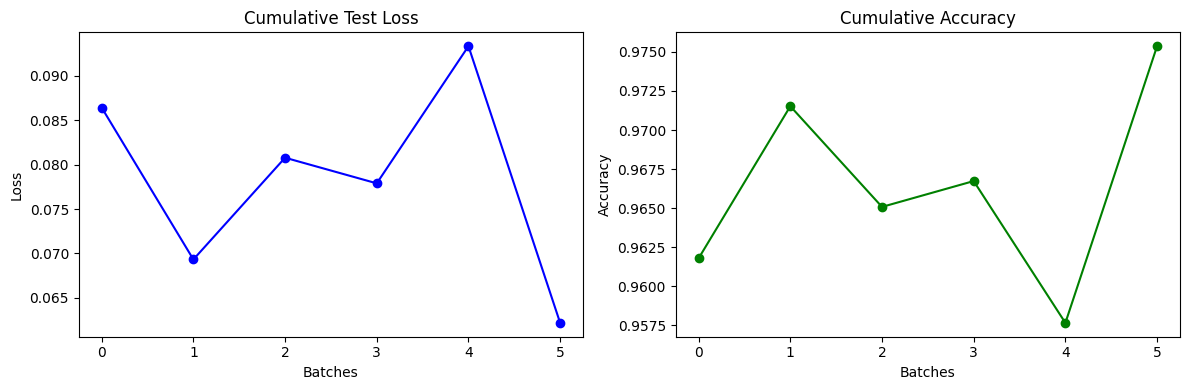

In [52]:
import matplotlib.pyplot as plt

# Assuming loaded_model is your pre-trained model
test_data = DataGenerator(test_ids, test_mask)

# Convert DataGenerator into an iterator
test_data_iterator = iter(test_data)

# Initialize lists to store cumulative results
test_losses = []
test_accuracies = []

# Set the desired number of batches
num_batches = 30
batch_count = 0

# Iterate over batches in the test set up to the desired number of batches
while batch_count < num_batches:
    try:
        # Get the next batch from the test data generator
        batch_x, batch_y = next(test_data_iterator)

        # Evaluate the model on the batch
        loss, accuracy = loaded_model.evaluate(batch_x, batch_y, verbose=0)

        # Append results to lists
        test_losses.append(loss)
        test_accuracies.append(accuracy)

        batch_count += 1
    except StopIteration:
        break

# Plotting the cumulative results
plt.figure(figsize=(12, 4))

# Plot Cumulative Test Loss
plt.subplot(1, 2, 1)
plt.plot(test_losses, marker='o', linestyle='-', color='blue')
plt.title('Cumulative Test Loss')
plt.xlabel('Batches')
plt.ylabel('Loss')

# Plot Cumulative Test Accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, marker='o', linestyle='-', color='green')
plt.title('Cumulative Accuracy')
plt.xlabel('Batches')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
